In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [2]:
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from matplotlib.pyplot import figure
from keras import backend as K

import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
import numpy as np
import pandas as pd
import scipy
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report

Using TensorFlow backend.


In [3]:
tf_config = K.tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
session = K.tf.Session(config=tf_config)
K.set_session(session)

In [4]:
from keras import backend as K
import tensorflow as tf

# Compatible with tensorflow backend

def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [5]:
model = load_model('/data/Data/yntn/model_LSTM_w14_focallLoss_TrainCsv.hdf5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})

In [6]:
# df = pd.read_csv ('/data/Data/yntn/data_labeled_10M.csv')
df = pd.read_csv ('/data/Data/yntn/train.csv')

# df = pd.read_csv ('/data/Data/yntn/test.csv')

In [7]:
label_tag = (list(set (df.label)))
label_tag.sort()
cutdata = []
for i in range (len(label_tag)):
    df_go = df[df.label == label_tag[i]].head(350000)    
    cutdata.append(df_go)
go = pd.concat(cutdata, axis = 0)

In [7]:
word_dict = pickle.load (open("/data/Data/yntn/word_embedding_vec.pkl",'rb'))

In [8]:
tok = pickle.load (open("/data/Data/yntn/emotion-detection-from-text/tokenize.pkl",'rb'))

In [10]:
Y = df.target
le = LabelEncoder()
Y = le.fit_transform(Y)

In [10]:
# # X = df.status
# # Y = df.target
# X = df.text
# Y = df.label
# le = LabelEncoder()
# Y = le.fit_transform(Y)

In [12]:
def detect_emotion(arr):
    max_words = 88860
    max_len = 30
    test = [str(s) for s in arr]
    sequences = tok.texts_to_sequences(test)
    sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
    emotion = []
    print(sequences_matrix.shape)
    rs = model.predict( sequences_matrix , batch_size=1024, verbose=1, steps=None)
    return (rs)

In [11]:
# X = go.text
# Y = go.label
X = df.status
Y = df.target

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 42)

In [14]:
# test_list = X_test.tolist()
# label_list = le.transform(Y_test.tolist())

test_list = X_test.tolist()
label_list = le.transform(Y_test.tolist())

In [15]:
final = detect_emotion(test_list)

(837183, 30)
837183/837183 [==============================] - 10s 12us/step


In [16]:
final = np.argmax(final,axis=1)

TÍNH F1

In [17]:
precision_score(label_list, final, average='macro')

0.23464984744663425

In [18]:
recall_score(label_list, final, average='macro')

0.2152631940550366

In [19]:
f1_score(label_list, final, average='macro')

0.2063718112582867

CONFUSION MATRIX

In [20]:
cm = confusion_matrix(label_list, final)

In [21]:
import seaborn

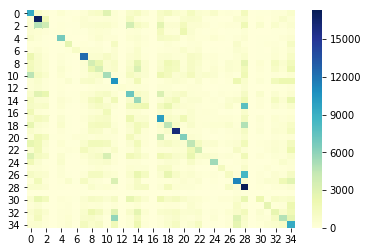

In [22]:
seaborn.heatmap(cm, cmap="YlGnBu")

In [23]:
x=[sum(cm[i]) - cm[i,i] for i in range (35)]
y=[sum(cm[i]) for i in range (35)]

In [24]:
cm_pcnt  = [cm[i]/y[i]*100 for i in range (35)]

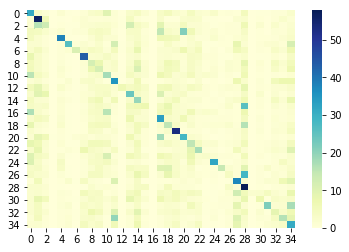

In [25]:
seaborn.heatmap(cm_pcnt, cmap="YlGnBu")

CORRELATION

In [26]:
tag_label = [(str(le.inverse_transform([i])[0])) for i in range(35)]

In [29]:
cls_report = classification_report(label_list, final, target_names=tag_label, output_dict=True)

In [28]:
outfile = "classification_report_w14_focallLoss_TrainCsv.txt"
with open(outfile, "w") as f:
    f.write(cls_report)

In [30]:
arr_f1_score = []
arr_support = []
for i in range (35):    
    arr_f1_score.append(cls_report[tag_label[i]]['f1-score'])
    arr_support.append(cls_report[tag_label[i]]['support'])                   

In [31]:
np.corrcoef(arr_f1_score, arr_support)

array([[1.        , 0.22147524],
       [0.22147524, 1.        ]])

In [32]:
scipy.stats.spearmanr(arr_f1_score, arr_support)

SpearmanrResult(correlation=0.18026472486254164, pvalue=0.30008594437902675)

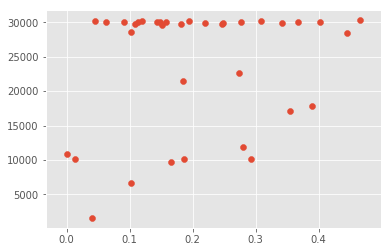

In [33]:
import matplotlib
# import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.style.use('ggplot')

plt.scatter(arr_f1_score, arr_support)
plt.show()

In [34]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt

In [42]:
with open("stop_word.txt",'r') as f :
    sw = f.readlines()
for i in range (len(sw)):
    sw[i] = sw[i].strip('\n')

In [36]:
def word_cloud_plot(text,label):    
    wordcloud = WordCloud().generate(text)
    wordcloud = WordCloud(background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.savefig("word_cloud_TrainCsv_focal-loss/" + label +".png")

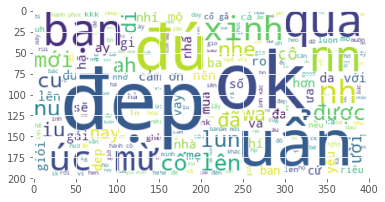

In [43]:
for i in range(35):
    data = df.status[df.target == tag_label[i]]
    text = " ".join(str(row) for row in data)   
    for j in range(len(sw)):
        if (i in[0,10,6,18,28,30]):
            if (sw[j] == "hả"):
                continue
        text = text.replace(sw[j],'')
#     if i == 4:
#         text = text.replace('chị','')
    word_cloud_plot(text,tag_label[i])

In [9]:
tag_label = (list(set(df.label)))

In [10]:
tag_label.sort()